# Import packages needed for mappdf demo

In [1]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy.stats import pearsonr

from diffpy.pdfgetx import PDFGetter, PDFConfig

# utils for mapPDF
from utils import *

# bSeabornStyle()

# Define filepath to informations

In [2]:
# defined example files
meta_data_fp = 'meta/20161115-220716_grid_scan_md2.txt'
chi_dir = 'chi/'
background_fp = 'background/PCA_background.txt'

# Load raw I(Q) data

In [3]:
# load lookup table
# optional; to exclude function
qoi_colmns  = ['diff_x', 'diff_y', 'filename']
df = mappdf_load_chi(meta_data_fp, qoi_columns=qoi_colmns, root=chi_dir)

# load real background
bkg_q, bkg_Iq = np.loadtxt(background_fp).T

In [4]:
# view the first 5 rows for example
df.head()

,diff_x,diff_y,filename,q,iq
0,9.4,25.44,Catalyst_Array_DenseMap_075785_0001.chi,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.7301698, 5.7302208..."
1,9.4,24.44,Catalyst_Array_DenseMap_075785_0002.chi,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.0435905, 4.0436268..."
2,9.4,23.44,Catalyst_Array_DenseMap_075785_0003.chi,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.0133491, 5.0133934..."
3,9.4,22.44,Catalyst_Array_DenseMap_075785_0004.chi,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.7433209, 4.7433634..."
4,9.4,21.44,Catalyst_Array_DenseMap_075785_0005.chi,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 3.9600918, 3.9601269..."


# Pearson map of I(Q) wrt backgrounds for first screening 

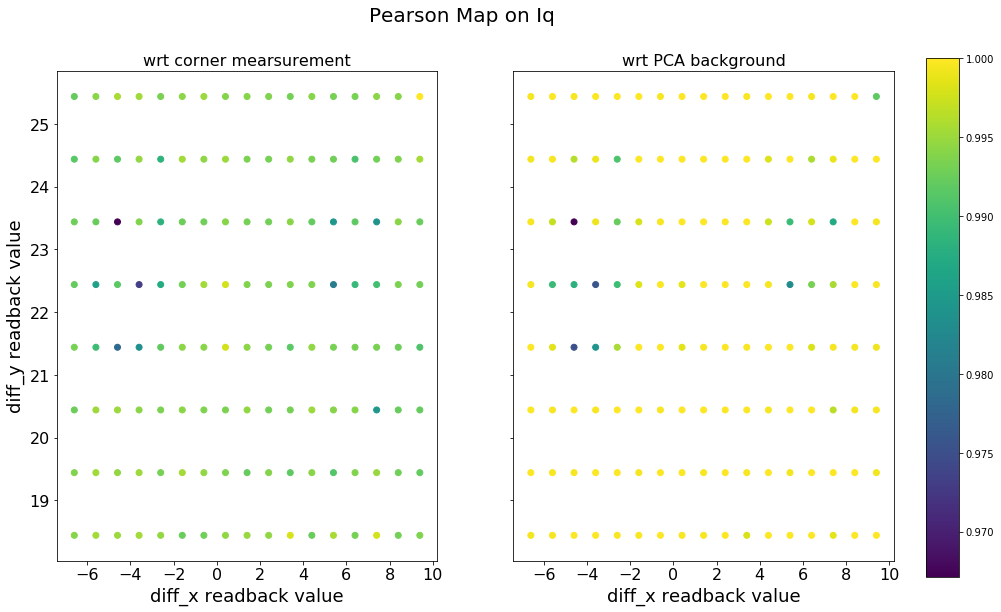

In [5]:
plt.set_cmap('inferno')
# pearson map
df['pearson1'] = [pearsonr(i, df['iq'][0])[0] for i in df['iq']]
df['pearson2'] = [pearsonr(i, bkg_Iq)[0] for i in df['iq']]

# create scatter plot with pearson map
fig, ax = plt.subplots(1,2, figsize=(15,9), sharey=True)
fig.suptitle('Pearson Map on Iq', fontsize=20)
cax = fig.add_axes((0.93,0.1,0.03,0.8))
im = ax[0].scatter(df['diff_x'], df['diff_y'], c=df['pearson1'])
ax[1].scatter(df['diff_x'], df['diff_y'], c=df['pearson2'])
fig.colorbar(im, cax=cax)

ax[0].set_title('wrt corner mearsurement', fontsize=16)
ax[1].set_title('wrt PCA background', fontsize=16)
ax[0].set_ylabel('diff_y readback value')
for el in ax:
    el.set_xlabel('diff_x readback value')
    conf_label_size(el, 18)
    conf_tick_size(el, 16)

# Subtracting background to extract signal

In [6]:
df['iq_subPCA'] = df['iq'] - bkg_Iq
df['iq_subCorner'] = df['iq'] - df['iq'][0]

# Process I(Q) to PDF

In [7]:
# define transformation config
base_config = dict(qmaxinst=17, qmin=0.8, qmax=17, dataformat='Qnm',
                   rmin=0.0, rmax=100.0, rstep=0.01)

# define composition per row
composition_list = ['CPtCu']*len(df)

# transform Iq
Gr_array_PCA = []
Gr_array_corner = []
pdfgetter = PDFGetter()
for name, Iq_list in zip(['_PCA', '_Corner'], [df['iq_subPCA'], df['iq_subCorner']]):
    df['gr'+name] = [pdfgetter(q, iq, composition=comp, **base_config)[1] 
               for q, iq, comp in zip(df['q'], Iq_list, composition_list)]

# transform PCA Iq
r, PCA_bkg_Gr = pdfgetter(bkg_q, bkg_Iq, composition='C', **base_config)

# Visualize 95% confidence interval (CI) of transformed Gr_array

Text(0,0.5,'G($\\mathrm{\\AA}^{-2}$)')

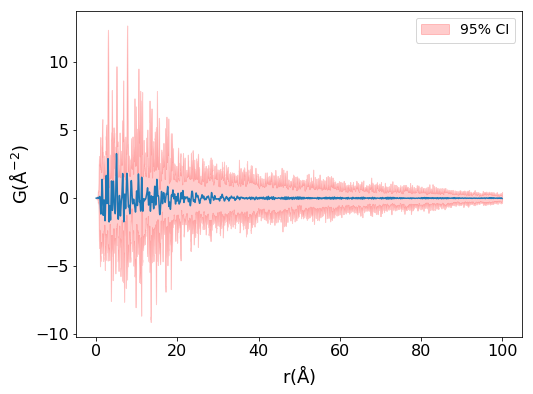

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
low, high = np.percentile(np.asarray(list(df['gr_PCA'])), axis=0, q=[2.5, 97.5])
ax.plot(r, df['gr_PCA'].mean(0))
ax.fill_between(r, low, high, color='r', alpha=0.2, label='95% CI')
ax.legend(fontsize=14)
conf_label_size(ax, 18)
conf_tick_size(ax, 16)
ax.set_xlabel(r'r($\mathrm{\AA}$)')
ax.set_ylabel(r'G($\mathrm{\AA}^{-2}$)')

Text(0,0.5,'G($\\mathrm{\\AA}^{-2}$)')

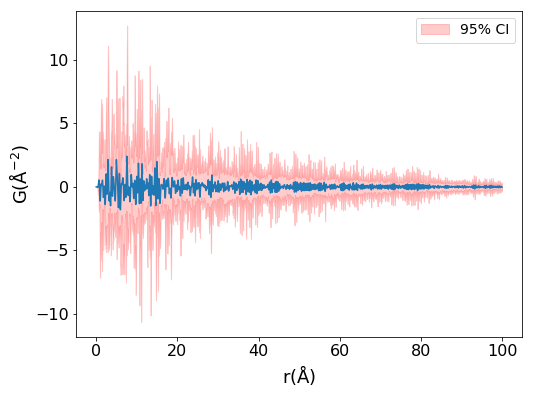

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
low, high = np.percentile(np.asarray(list(df['gr_Corner'])), axis=0, q=[2.5, 97.5])
ax.plot(r, df['gr_Corner'].mean(0))
ax.fill_between(r, low, high, color='r', alpha=0.2, label='95% CI')
ax.legend(fontsize=14)
conf_label_size(ax, 18)
conf_tick_size(ax, 16)
ax.set_xlabel(r'r($\mathrm{\AA}$)')
ax.set_ylabel(r'G($\mathrm{\AA}^{-2}$)')

# Pearson map of G(r)

/home/christopher/mc/envs/dp_dev/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


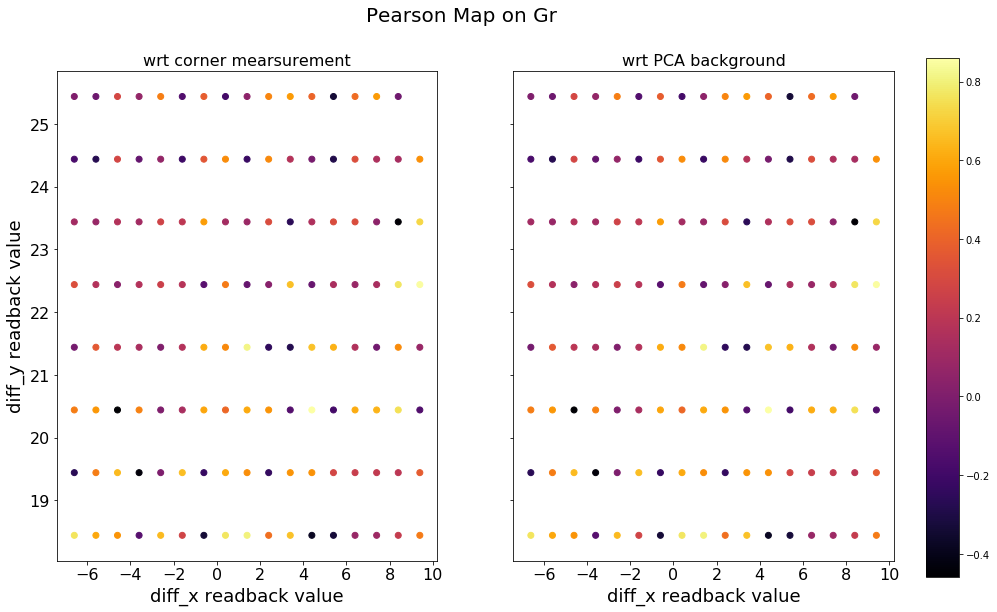

In [11]:
# pearson map
df['gr_pearson1'] = [pearsonr(i, PCA_bkg_Gr)[0] for i in df['gr_Corner']]
df['gr_pearson2'] = [pearsonr(i, PCA_bkg_Gr)[0] for i in df['gr_PCA']]

# create scatter plot with pearson map
fig, ax = plt.subplots(1,2, figsize=(15,9), sharey=True)
fig.suptitle('Pearson Map on Gr', fontsize=20)
cax = fig.add_axes((0.93,0.1,0.03,0.8))
im = ax[0].scatter(df['diff_x'], df['diff_y'], c=df['gr_pearson1'])
ax[1].scatter(df['diff_x'], df['diff_y'], c=df['gr_pearson1'])
fig.colorbar(im, cax=cax)

ax[0].set_title('wrt corner mearsurement', fontsize=16)
ax[1].set_title('wrt PCA background', fontsize=16)
ax[0].set_ylabel('diff_y readback value')
for el in ax:
    el.set_xlabel('diff_x readback value')
    conf_label_size(el, 18)
    conf_tick_size(el, 16)
plt.set_cmap('inferno')